In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization import LinearStretch, SqrtStretch, ImageNormalize, PercentileInterval
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import mad_std
from scipy.ndimage import median_filter

In [2]:
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LinearSpectrograph
from lvmdatasimulator.simulator import Simulator
from lvmdatasimulator.fibers import FiberBundle

# LVM simulated observation of AzV 255 in the SMC.

## Prepare and display cutout median filtered image

In [3]:
def conditional_medfilt(array, size, clip):
    filtered = median_filter(array, size=size, mode='wrap')
    mask = (abs((array-filtered)/filtered) > clip)
    new_array = np.copy(array)
    new_array[mask] = filtered[mask]
    return new_array

In [4]:
srcname = 'SMC_AV255'

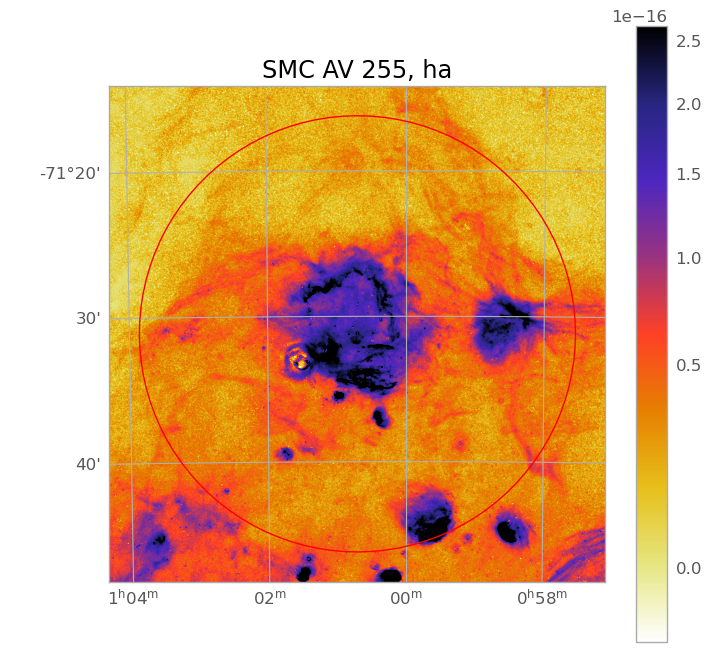

In [5]:
mcelsdir = os.path.expanduser('~/Data/mcels_smc/')

# Median filtering parameters
size = 15
clip = 2

tgt  = "AV 255"
line = 'ha'

rapos = {"AV 255": "01h00m42.078s",
         "AV 435": "01h08m17.908s",
        }
         
dcpos = {"AV 255": "-71d31m12.2723s",
         "AV 435": "-71d59m54.386s",
        }

# Prepare the subimages
c = SkyCoord(rapos[tgt], dcpos[tgt], frame='fk5')
if not os.path.isfile(f'{srcname}.{line}.scale.fits'):
    dat, hd = fits.getdata(mcelsdir+'mosaic_ha_02_sub.37.fits', header=True)
    wcs = WCS(hd)
    print('Working on',tgt,line)
    x, y = wcs.world_to_pixel(c)
    cutout = Cutout2D(dat, position=(x,y), size=(1024,1024), wcs=wcs)
    newhd = cutout.wcs.to_header()
    newdat = cutout.data
    fits.writeto(f'{srcname}.{line}.csub.fits', newdat, 
                 newhd, overwrite=True)
    medfilt = conditional_medfilt(newdat, size, clip)
    medfilt[medfilt < -100] = 0.
    fits.writeto(f'{srcname}.{line}.filt{size}clip{clip}.fits',
                 medfilt, header=newhd, overwrite=True)
    medfilt *= 1e-17/4
    fits.writeto(f'{srcname}.{line}.scale.fits',
                 medfilt, header=newhd, overwrite=True)
else:
    medfilt, newhd = fits.getdata(f'{srcname}.{line}.scale.fits', header=True)
fig = plt.figure(figsize=(8,8))
w = WCS(newhd)
ax = fig.add_subplot(projection=w)
norm = ImageNormalize(medfilt, interval=PercentileInterval(98),
                      stretch=SqrtStretch())
im = ax.imshow(medfilt, norm=norm, origin='lower', cmap='CMRmap_r')
reg = SphericalCircle(c, 0.25*u.deg, edgecolor='red', facecolor='none',
             transform=ax.get_transform('fk5'))
ax.add_patch(reg)
ax.set_title(f'SMC {tgt}, {line}')
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
plt.colorbar(im, ax=ax)

## Create a simulation based on the MCELS data using a CLOUDY model.
## Model: Shell_409, Z=0.2, qH=47.5, logLsun=4, Teff=30000, nH=30, Rin=10.01, Rout=10.08 -- this model didn't show any non-hydrogen lines.
## Model: Shell_205, Z=0.4, qH=49.3, logLsun=5.5, Teff=50000, nH=30, Rin=10.01, Rout=12.04

In [6]:
pxsize = 2 * u.arcsec
mcels_ha  = fits.getdata(srcname+'.ha.scale.fits')
fov_size = 35
fov_pixel = 2

In [7]:
wcs = WCS(fits.getheader(srcname+'.ha.scale.fits')) 
coord = wcs.pixel_to_world([512],[512])  
ra = coord.ra.degree[0]
dec = coord.dec.degree[0]
print('Image center:',ra,dec)

Image center: 15.174334136330287 -71.5199715922772


In [8]:
name = srcname+'_ex1'

my_lvmfield = LVMField(ra, dec, fov_size, fov_pixel, name=name)
my_lvmfield.generate_gaia_stars(gmag_limit=11)

my_nebulae = [
        {"type": 'DIG', 'max_brightness': 1e-17 * u.erg / u.cm ** 2 / u.s / u.arcsec ** 2,
         'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc},
        {"type": 'CustomNebula', 'brightness_map': mcels_ha, 'model_type': 'cloudy',
         'model_id': 'Shell_205', 'offset_RA': 0, 'offset_DEC': 0, 'pxsize': pxsize} ]
my_lvmfield.add_nebulae(my_nebulae, save_nebulae=name+".fits", overwrite=True)

[INFO]: 40926 Gaia stars in the field
[INFO]: 40920 stars are fainter than 11 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
[INFO]: Rescaling 6 synthetic spectra.
[INFO]: Saving star list to: ./SMC_AV255_ex1/SMC_AV255_ex1_starlist.fits.gz


INFO: Query finished. [astroquery.utils.tap.core]


[INFO]: Start generating 2 nebulae
[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_227'. Its parameters: Geometry = Cloud; Z = 0.8; nH = 100.0; Teff = 40000.0; LogLsun = 6.0; 
[INFO]: Generated ISM saved to ./SMC_AV255_ex1/SMC_AV255_ex1.fits
[INFO]: ISM content saved to SMC_AV255_ex1.fits


[INFO]: Using the full hexagon pattern
[INFO]: Input image in 6540.0-6600.0AA wavelength range is saved to SMC_AV255_ex1_6540_6600_input_map.fits
[INFO]: Input image in 6700.0-6750.0AA wavelength range is saved to SMC_AV255_ex1_6700_6750_input_map.fits
[WARNING]: Bundle center coords are not defined, using the coords of the field.


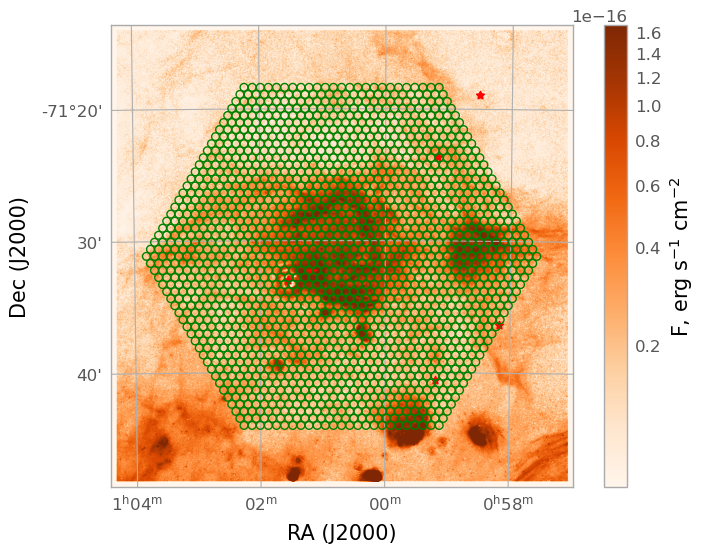

In [9]:
tel = LVM160()
spec = LinearSpectrograph()
bundle = FiberBundle(bundle_name='full')
my_lvmfield.get_map(wavelength_ranges=([6540,6600],[6700,6750]))
my_lvmfield.show(fibers=bundle.fibers_science, outname=name+"_fibers.png")

In [10]:
bundle = FiberBundle(bundle_name='full')
exptimes = [1200, 120] # in seconds
obs = Observation(ra=ra, dec=dec, exptimes=exptimes)
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)
sim.simulate_observations()
sim.save_outputs()
sim.save_output_maps(wavelength_ranges=([6540,6600],[6700,6750]))

[INFO]: Using the full hexagon pattern
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 10 days from new moon.
[INFO]: Using sky file: /Users/tonywong/Library/Python/3.9/lib/python/data/sky/LVM_LVM160_SKY_10.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 1801 fibers.
[INFO]: Start extracting nebular spectra
[INFO]: Dividing the array in 4 with an overlap of 20.900000000000002 arcsec
[INFO]: Dividing the array in 4 with an overlap of 20.900000000000002 arcsec
[INFO]: Resampling spectra to the instrument wavelength solution.
[INFO]: Saving the outputs:
[INFO]: Input spectra
[INFO]: ./SMC_AV255_ex1/outputs/SMC_AV255_ex1_linear_full_input.fits saved.
[INFO]: Clean outputs
[INFO]: ./SMC_AV255_ex1/outputs/SMC_AV255_ex1_linear_full_1200_no_noise.fits saved.
[INFO]: ./SMC_AV255_ex1/outputs/SMC_A

## Plot the results.  Left is Hα+NII, right is SII.  

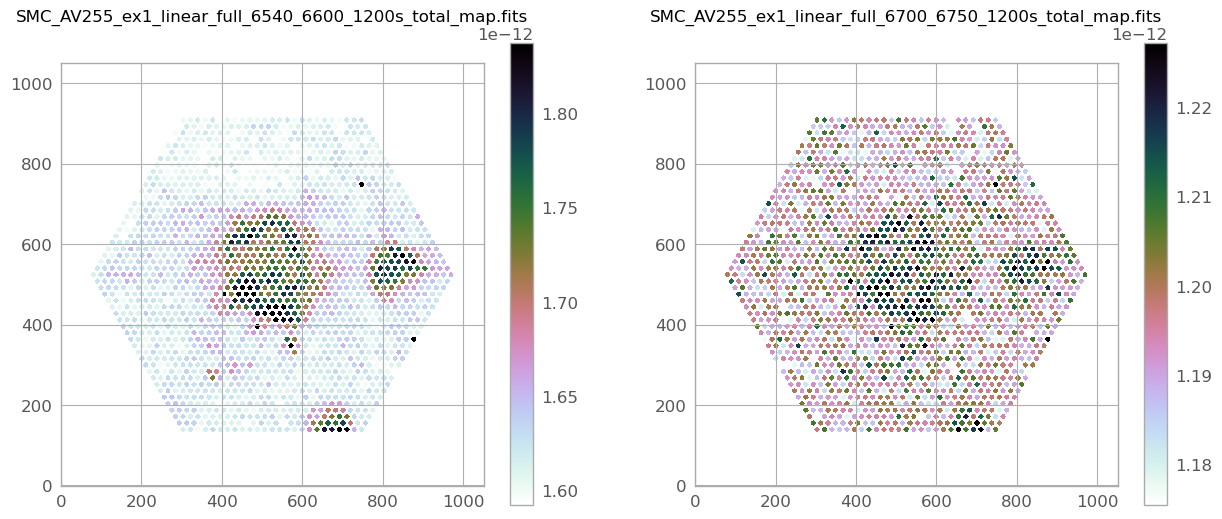

In [11]:
for name in [srcname+'_ex1']:
    fig, axs = plt.subplots(1, 2, figsize=(15,6))
    imgs = [f"{name}/outputs/{name}_linear_full_6540_6600_1200s_total_map.fits",
            f"{name}/outputs/{name}_linear_full_6700_6750_1200s_total_map.fits"]
    for i, img in enumerate (imgs):
        imdata = fits.getdata(img)
        imdata[imdata==0] = np.nan
        norm = ImageNormalize(imdata, interval=PercentileInterval(98),stretch=LinearStretch())
        im = axs[i].imshow(imdata, norm=norm, origin='lower', cmap='cubehelix_r')
        axs[i].set_title(os.path.basename(img),pad=30,fontsize='medium')
        plt.colorbar(im, ax=axs[i])

## Spectra of long wavelength region.

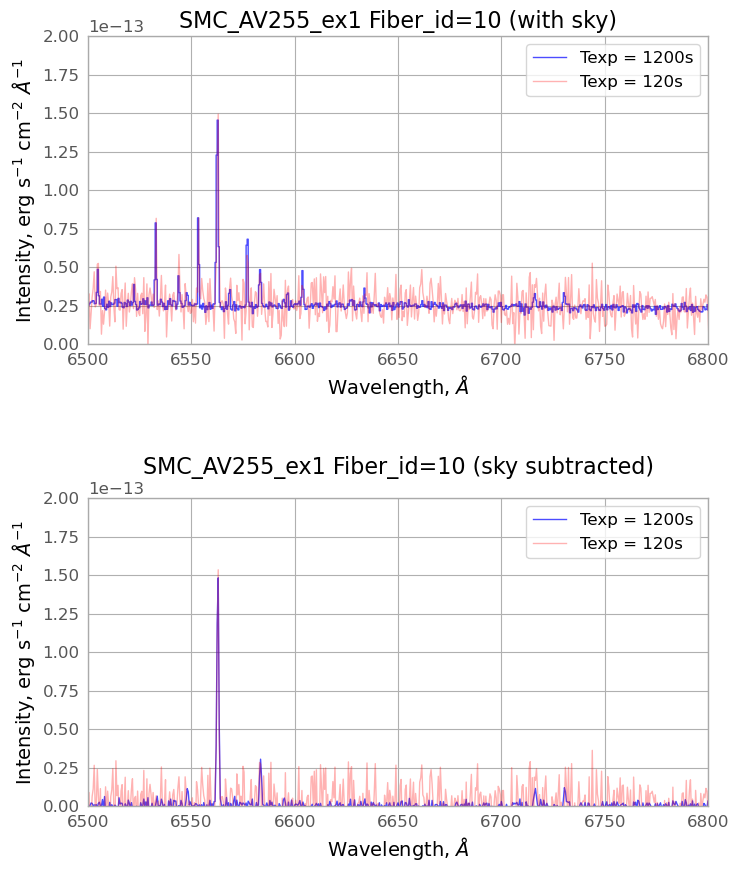

In [12]:
for name in [srcname+'_ex1']:
    fig = plt.figure(figsize=(8,10))
    fiber_id = 10
    with fits.open(f"{name}/outputs/{name}_linear_full_{exptimes[0]}_flux.fits") as hdu:
        wave = hdu['Wave'].data
        flux_short_exp = hdu['TOTAL'].data[fiber_id]
        flux_short_exp_nosky = hdu['TARGET'].data[fiber_id]
    with fits.open(f"{name}/outputs/{name}_linear_full_{exptimes[1]}_flux.fits") as hdu:
        flux_large_exp = hdu['TOTAL'].data[fiber_id]
        flux_large_exp_nosky = hdu['TARGET'].data[fiber_id]
    ax = plt.subplot(211)
    plt.step(wave, flux_short_exp, linewidth=1, label=f"Texp = {exptimes[0]}s", alpha=0.7, color='b')
    plt.plot(wave, flux_large_exp, linewidth=1, label=f'Texp = {exptimes[1]}s', alpha=0.3, color='r')
    plt.legend()
    plt.xlabel("Wavelength, $\AA$",fontsize=14)
    plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
    plt.ylim(0,2e-13)
    plt.xlim(6500,6800)
    plt.title(f"{name} Fiber_id={fiber_id} (with sky)", fontsize=16)

    ax = plt.subplot(212)
    plt.plot(wave, flux_short_exp_nosky, linewidth=1, label=f"Texp = {exptimes[0]}s", alpha=0.7, color='b')
    plt.plot(wave, flux_large_exp_nosky, linewidth=1, label=f'Texp = {exptimes[1]}s', alpha=0.3, color='r')
    plt.legend()
    plt.xlabel("Wavelength, $\AA$",fontsize=14)
    plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
    plt.ylim(0,2e-13)
    plt.xlim(6500,6800)
    plt.title(f"{name} Fiber_id={fiber_id} (sky subtracted)", fontsize=16);

## Spectra of short wavelength region.

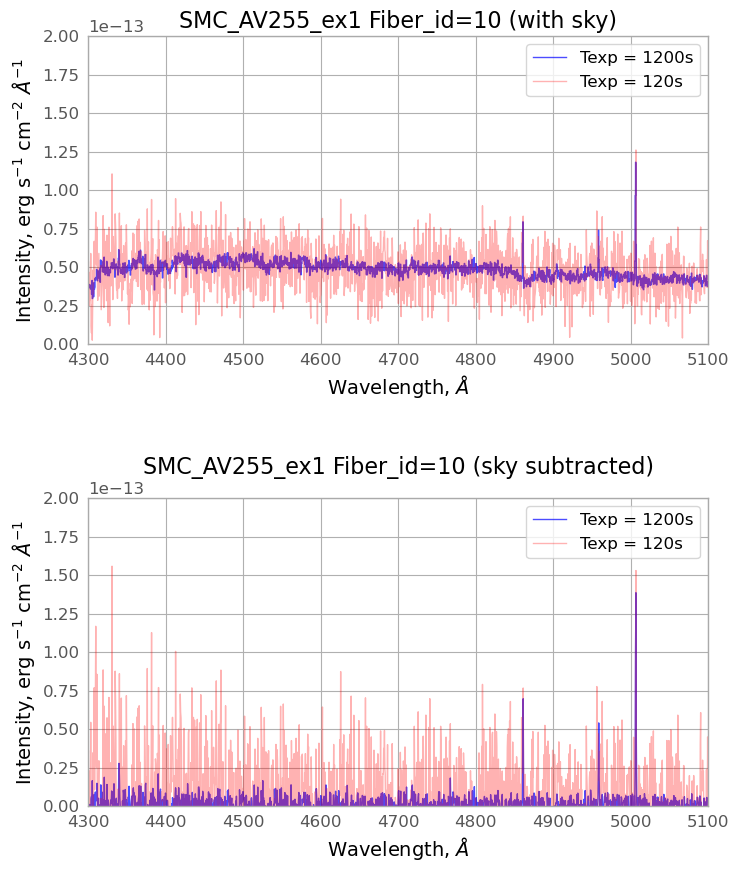

In [13]:
for name in [srcname+'_ex1']:
    fig = plt.figure(figsize=(8,10))
    fiber_id = 10
    with fits.open(f"{name}/outputs/{name}_linear_full_{exptimes[0]}_flux.fits") as hdu:
        wave = hdu['Wave'].data
        flux_short_exp = hdu['TOTAL'].data[fiber_id]
        flux_short_exp_nosky = hdu['TARGET'].data[fiber_id]
    with fits.open(f"{name}/outputs/{name}_linear_full_{exptimes[1]}_flux.fits") as hdu:
        flux_large_exp = hdu['TOTAL'].data[fiber_id]
        flux_large_exp_nosky = hdu['TARGET'].data[fiber_id]
    ax = plt.subplot(211)
    plt.step(wave, flux_short_exp, linewidth=1, label=f"Texp = {exptimes[0]}s", alpha=0.7, color='b')
    plt.plot(wave, flux_large_exp, linewidth=1, label=f'Texp = {exptimes[1]}s', alpha=0.3, color='r')
    plt.legend()
    plt.xlabel("Wavelength, $\AA$",fontsize=14)
    plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
    plt.ylim(0,2e-13)
    plt.xlim(4300,5100)
    plt.title(f"{name} Fiber_id={fiber_id} (with sky)", fontsize=16)

    ax = plt.subplot(212)
    plt.plot(wave, flux_short_exp_nosky, linewidth=1, label=f"Texp = {exptimes[0]}s", alpha=0.7, color='b')
    plt.plot(wave, flux_large_exp_nosky, linewidth=1, label=f'Texp = {exptimes[1]}s', alpha=0.3, color='r')
    plt.legend()
    plt.xlabel("Wavelength, $\AA$",fontsize=14)
    plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
    plt.ylim(0,2e-13)
    plt.xlim(4300,5100)
    plt.title(f"{name} Fiber_id={fiber_id} (sky subtracted)", fontsize=16);

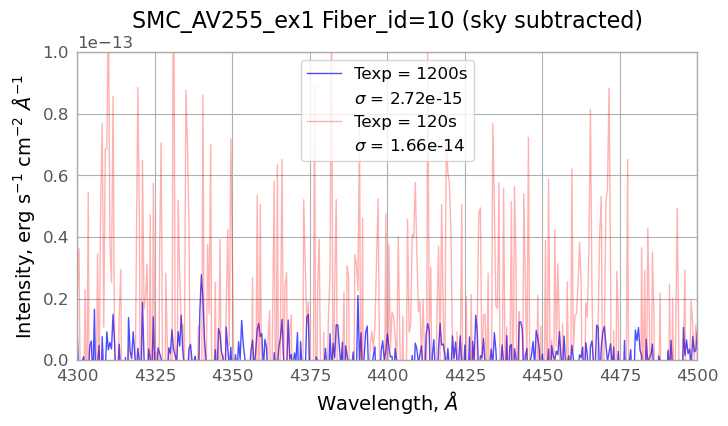

In [14]:
fig = plt.figure(figsize=(8,10))
fiber_id = 10
for i, name in enumerate([srcname+'_ex1']):
    ax = plt.subplot(2,1,i+1)
    with fits.open(f"{name}/outputs/{name}_linear_full_{exptimes[0]}_flux.fits") as hdu:
        wave = hdu['Wave'].data
        flux_short_exp_nosky = hdu['TARGET'].data[fiber_id]
    with fits.open(f"{name}/outputs/{name}_linear_full_{exptimes[1]}_flux.fits") as hdu:
        flux_large_exp_nosky = hdu['TARGET'].data[fiber_id]
    ax.plot(wave, flux_short_exp_nosky, linewidth=1, label=f"Texp = {exptimes[0]}s", alpha=0.7, color='b')
    ax.plot([], [], ' ', label=f'$\sigma$ = {mad_std(flux_short_exp_nosky):.2e}')
    ax.plot(wave, flux_large_exp_nosky, linewidth=1, label=f'Texp = {exptimes[1]}s', alpha=0.3, color='r')
    ax.plot([], [], ' ', label=f'$\sigma$ = {mad_std(flux_large_exp_nosky):.2e}')
    plt.legend()
    plt.xlabel("Wavelength, $\AA$",fontsize=14)
    plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
    plt.ylim(0,1e-13)
    plt.xlim(4300,4500)
    plt.title(f"{name} Fiber_id={fiber_id} (sky subtracted)", fontsize=16);